How would you prove that
$$
f(x) = \sinh(x) - \frac{1}{2}\left(\frac{\cosh(x)}{\cosh(x-a)}\right)^{x/a} \ge 0
$$
for $a = \log(2)/2$ and all $x > 0$.

If you have Mathematica, this is not hard. You can also do the same thing with pencil and paper, but it will take you a bit longer 😌. 

However, there is a third way. 
You can use [interval arithmetic](https://en.wikipedia.org/wiki/Validated_numerics). 
These are computer algorithms and softwares that compute numeric values of mathematical function with **guaranteed** error bounds. 

In other words, these algorithms will not only give you an upper and lower bounds of $f(x)$,
but also also **prove** these bounds are correct. 😮! 

In this post, I will show you how this can be done using [Julia](https://julialang.org/),  a high-efficiency programming language that looks like Python but faster.  It is currently my favourite choice of programming.

## Preparation

Let's install all the interval arithmetic packages that we will need if you don't already have them.

In [ ]:
using Pkg;
Pkg.activate(".")
Pkg.add("IntervalArithmetic");
Pkg.add("IntervalRootFinding");
Pkg.add("ForwardDiff")
Pkg.add("Plots")
Pkg.add("GR"); 

## Proof by picture

Before we try it, it is always a good idea to see if what we are trying to prove is true on a picture. (Same reason people like tinder.)

The expression has a constant $a$ in it, which is not a rational number. So to keep all the computations rigours, let's make it an interval. (Yes, in interval arithematic, all numbers are intervals 🤦.) We use [`IntervalArithmetic.jl`](https://github.com/JuliaIntervals/IntervalArithmetic.jl) for this. 

In [2]:
using IntervalArithmetic

a = @interval 1/2*log((2))

┌ Info: Precompiling IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253]
└ @ Base loading.jl:1260


[0.346573, 0.346574]

These two number are **guaranteed** true lower and upper bound of the *true* value of $a$.

We can now define our $f(x)$.

In [3]:
f(x)=sinh(x) - 1/2 * (cosh(x)/cosh(x-a))^(x/a);

Let's try compute it at $1$

In [4]:
f(1)

[0.193128, 0.193129]

Because we have defined $a$ to be an interval, when we compute $f(1)$, we also get an interval. If we have defined $a$ to be of type `Float64`, we will get a `Float64` instead.

So this computation tells you that, the true value of $f(1)$ is guranteed to be between these two numbers. We do not see the proof. But in theory we can follow what the computer does line by line and get human proof.

Now the picture.

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


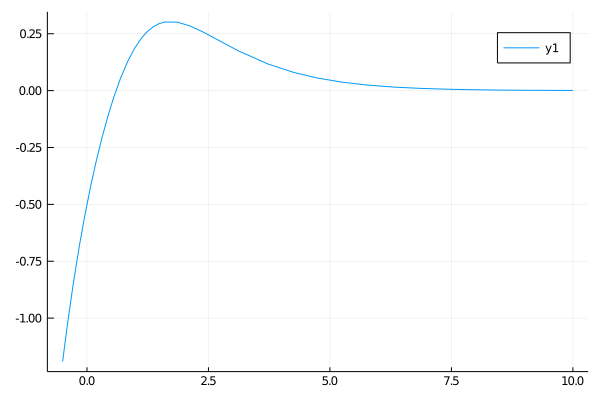

In [5]:
using Plots
gr()
plot(x->f(x).lo, -1/2, 10)

So I lied to you earlier 😑️. The function has a root on $(0,\infty)$. It looks like to be somewhere between $0$ and $1$. Let's see if this is true. And above this root, $f(x)$ seems to remain positve. Can we show this?

## The first (only?) root

We can try [`IntervalRootFinding.jl`](https://github.com/JuliaIntervals/IntervalRootFinding.jl) to find at least where the root is.

Because we have defined $a$ to be an interval, when we compute $f(1)$, we also get an interval. (If we have defined $a$ to be of type `Float64`, we will get a `Float64` instead.)

In [6]:
using IntervalRootFinding
roots(f, @interval(0, 1))

┌ Info: Precompiling IntervalRootFinding [d2bf35a9-74e0-55ec-b149-d360ff49b807]
└ @ Base loading.jl:1260


1-element Array{Root{Interval{Float64}},1}:
 Root([0.597845, 0.597846], :unique)

Yes! 
There is one root of $f(x)$ in $[0,1]$. The algorithm even tells you that it's unique.
We get a **true proof**  for this fact without breaking a sweat 😀️. 

## More roots?

The problem then is to show that there is no other roots. Let try $[1,2]$ first.

In [7]:
roots(f, @interval(1, 2))

0-element Array{Root{Interval{Float64}},1}

There is nothing. Let's try $[2,4]$

In [8]:
roots(f, @interval(2, 4))

0-element Array{Root{Interval{Float64}},1}

Again, no roots. 
But there are two problems here. 
First, it gets rather slow when you try larger interval, say $[4,8]$. 
Two, if the aim is to *prove* there are no roots on $[1, \infty]$, we will not be able to do this by checking finite many bounded intervals.

For some very simple functions, like $x$, $e^{2x}$, the algorithm can actually do it. But not our $f(x)$.

In [9]:
roots(x -> x, 1..∞)

0-element Array{Root{Interval{Float64}},1}

In [10]:
roots(x -> exp(x^2), 1..∞)

0-element Array{Root{Interval{Float64}},1}

## Simplified problem

So here's the truth about numeric methods. 
You can rarely avoid doing some symbolic computation.
You should combine both the strength of numeric and symbolic.

I massaged the problem a bit in Mathematica and found it is equivalent to show that
$$
\log (1-s)+\frac{\log \left(\frac{1}{2 e^2}\right) (\log (s+1)-\log (2 s+1))}{\log (2)} \ge 0 
$$
on $s \in [0,e^{-2}]$.
(Let's not to worry how I got it. That's not the point for today.)

Let's define another function $g(s)$ for the left-hand-side.

In [11]:
g(s) =  log(-s + 1)-(log(2*s + 1) - log(s + 1))*log(1/2/exp(2))/log(2)

g (generic function with 1 method)

How does it look like?

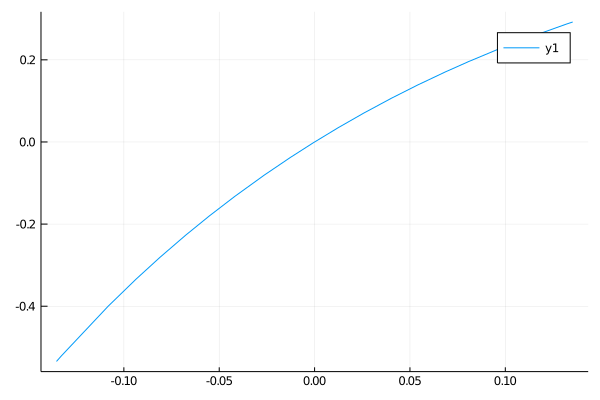

In [12]:
box = @interval -exp(-2) exp(-2)
plot(g, box.lo, box.hi)

So it looks like that there is only one root of $g(s)$ on $[-e^{-2}, e^{2}]$. Is it true?

In [13]:
roots(g, box)

1-element Array{Root{Interval{Float64}},1}:
 Root([-2.34965e-16, 1.79785e-16], :unique)

Yes! And we know *analytically* that $g(0)=0$. So $0$ is the only root of $g$. That means if $g(e^{-2})> 0$, $g(s)$ must remain non-negative between $0$ and $e^{-2}$. Let's check

In [14]:
b = @interval box.hi
g(b) >= 0

true

So we are done!

Alternatively, you can use [`ForwardDiff.jl`](https://github.com/JuliaDiff/ForwardDiff.jl) to show that the derivative of $g(s)$ is positive on the interval. Because then $g(s)$ must have only one root at $0$.

In [15]:
using ForwardDiff;

ForwardDiff.derivative(g, box) > 0

true

## Final thoughts

Let's recap what we have learned --

1. We can get guaranteed lower and upper numeric bounds for a function at fixed points, or on bounded interval.
1. If we want to prove something on unbounded interval, we shoud simplify the problem with symbolic computation. And try to convert the problem to bounded domain.
1. To show that a function has only one root on a bounded domain, you can either use `IntervalRootFinding.jl` directly, or use `ForwardDiff.jl` to show that the derivative is positive or negative.

Although is it truly necessary that we went through all these troubles?
Why cannot we believe the picture and move on with our life?
Isn't a picture is enough for most person to fall in love on Tinder?  😁